<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
rasterio==1.2.0
numpy==1.21.6
radiant_mlhub==0.4.1
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
pillow==7.1.2
monai==0.9.1
tensorboard==2.8.0

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

In [3]:
import os
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
import pylab as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss, MaskedDiceLoss
from monai.metrics import DiceMetric
# from torch.utils.tensorboard import SummaryWriter

/home/anna/anaconda3/envs/agri/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Specify global parameters

In [4]:
data_dir = 'data'
random_seed = 42

train_df_path = 'train_data.csv'

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 
              'B08','B8A', 'B09', 'B11', 'B12']

In [5]:
np.random.seed(random_seed)

## Download data from MLHUB


In [6]:
collection_name = 'ref_agrifieldnet_competition_v1'

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [7]:
if not os.path.exists(data_dir):
    os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

    dataset = Dataset.fetch(collection_name)
    dataset.download(output_dir=data_dir)
    for fn in os.listdir(data_dir):
        with tarfile.open(os.path.join(data_dir, fn)) as f:
            f.extractall(data_dir + '/') 
        os.remove(os.path.join(data_dir, fn))
else:
     print("Dataset already exists")

Dataset already exists


## Prepare Training data


### Create training dataframe

In [8]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths if 'labels_train' in fn]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [9]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

,folder_id,field_path,label_path,source_path
0,485ab,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
1,47271,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
2,1c08c,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
3,5c4fa,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
4,200d3,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...



## Extract field-crop data

In [10]:
def extract_field_crop_data(data):
    field_ids = []
    crop_types = []
    bands = []

    for i in tqdm(range(len(data))):
        with rasterio.open(data['field_path'].iloc[i]) as src:
            field_data = src.read()[0]
        with rasterio.open(data['label_path'].iloc[i]) as src:
            crop_data = src.read()[0]
        imgs = []
        for band in BAND_NAMES:
            with rasterio.open(data['source_path'].iloc[i] + rf"{band}.tif") as src:
                imgs.append(src.read()[0])

        for field_id in np.unique(field_data)[1:]:
            ind = np.where(field_data == field_id)
            crop_type = np.unique(crop_data[ind])[-1]
            field_ids = field_ids + [field_id] * len(ind[0])
            crop_types = crop_types + [crop_type] * len(ind[0])
            bands.append(np.array([img[ind] for img in imgs]).transpose())
            

    df = pd.DataFrame(np.concatenate(bands), columns=BAND_NAMES)
    df['field_id'] = field_ids
    df['crop_type'] = crop_types
    return df

In [11]:
df = extract_field_crop_data(train_data)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1165/1165 [00:37<00:00, 30.94it/s]


In [12]:
df = df.sort_values(['crop_type', 'field_id']).reset_index(drop=True)

In [13]:
df

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,crop_type
0,45,43,43,49,51,59,67,62,74,12,80,61,1,1
1,45,43,44,50,51,59,66,62,73,12,80,61,1,1
2,45,42,42,48,49,58,65,61,72,12,80,60,1,1
3,45,42,42,47,49,58,65,60,72,12,80,60,1,1
4,45,42,43,48,50,57,64,60,71,12,80,62,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188223,46,40,35,29,32,51,62,55,65,11,39,20,7332,36
188224,46,40,35,29,32,52,62,55,65,11,38,19,7332,36
188225,46,39,35,29,32,52,62,55,65,11,38,19,7332,36
188226,46,39,35,29,32,53,63,58,66,11,38,19,7332,36


## Extract labels

In [14]:
with open(f'{data_dir}/{train_label_collection}/{train_label_collection}'
          f'_{train_data.iloc[0]["folder_id"]}/stac.json') as ll:
    label_json = json.load(ll)

In [15]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

In [16]:
df['crop_label'] = df['crop_type'].apply(lambda x: crop_dict[x])

## Plot distributions

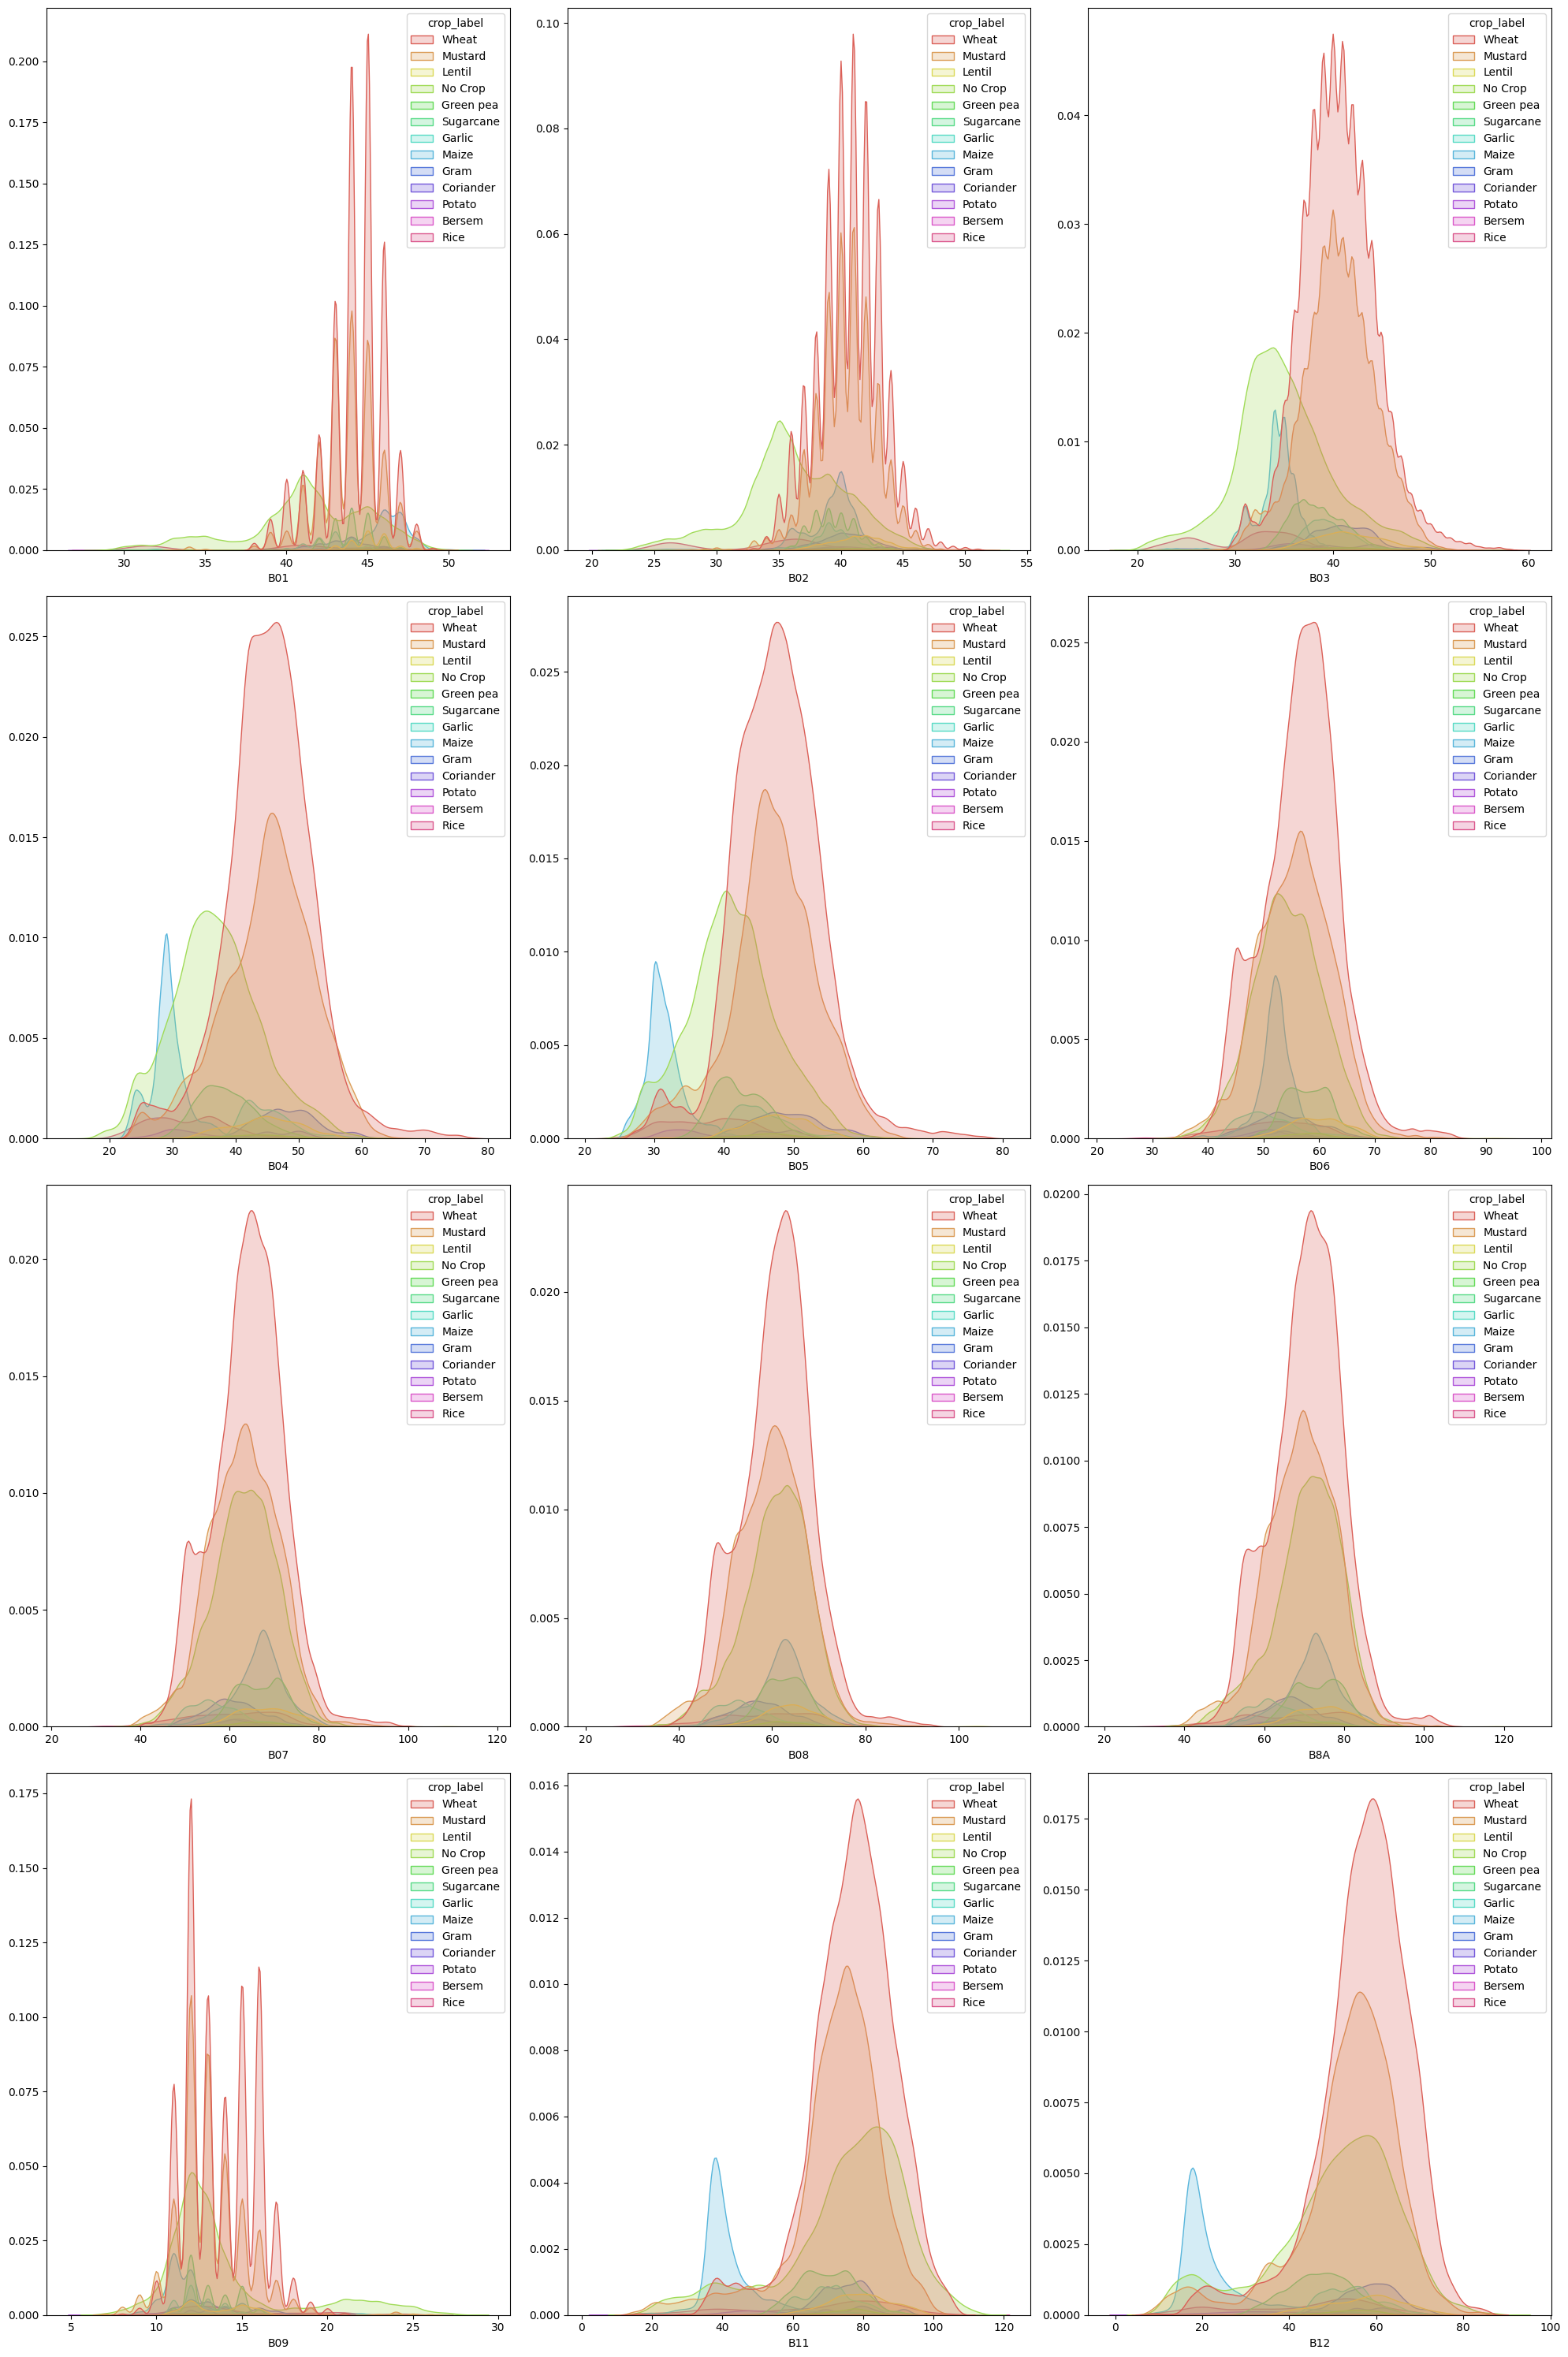

In [18]:
fig, axes = plt.subplots(4, 3, figsize = (20,30))
for ax, band in zip(axes.reshape(-1), BAND_NAMES):
    sns.kdeplot(x = band, hue='crop_label', data = df, 
                fill = True, ax = ax, 
                palette = sns.color_palette('hls', n_colors=13))
    ax.tick_params()
    ax.xaxis.get_label()
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [25]:
crop_labels = list(crop_dict.keys())
crop_labels.sort()
crop_names = [crop_dict[key] for key in crop_labels]
for i, (l, n) in enumerate(zip(crop_labels, crop_names)):
    print(i, l, n)

0 1 Wheat
1 2 Mustard
2 3 Lentil
3 4 No Crop
4 5 Green pea
5 6 Sugarcane
6 8 Garlic
7 9 Maize
8 13 Gram
9 14 Coriander
10 15 Potato
11 16 Bersem
12 36 Rice


## Add further indices
https://www.mdpi.com/2072-4292/13/23/4749/htm

In [29]:
BAND_NAMES

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12']

In [30]:
df['GCVI'] = df['B08'] / df['B03'] - 1
df['NBR1'] = (df['B08'] - df['B11']) / (df['B08'] + df['B11'])
df['NDTI'] = (df['B11'] - df['B12']) / (df['B11'] + df['B12'])
df['NDVI'] = (df['B08'] - df['B04']) / (df['B08'] + df['B04'])
df['SNDVI'] = (df['B08'] - df['B04']) / (df['B08'] + df['B04'] + 0.16)
ADD_BANDS = ['GCVI', 'NBR1', 'NDTI', 'NDVI', 'SNDVI']

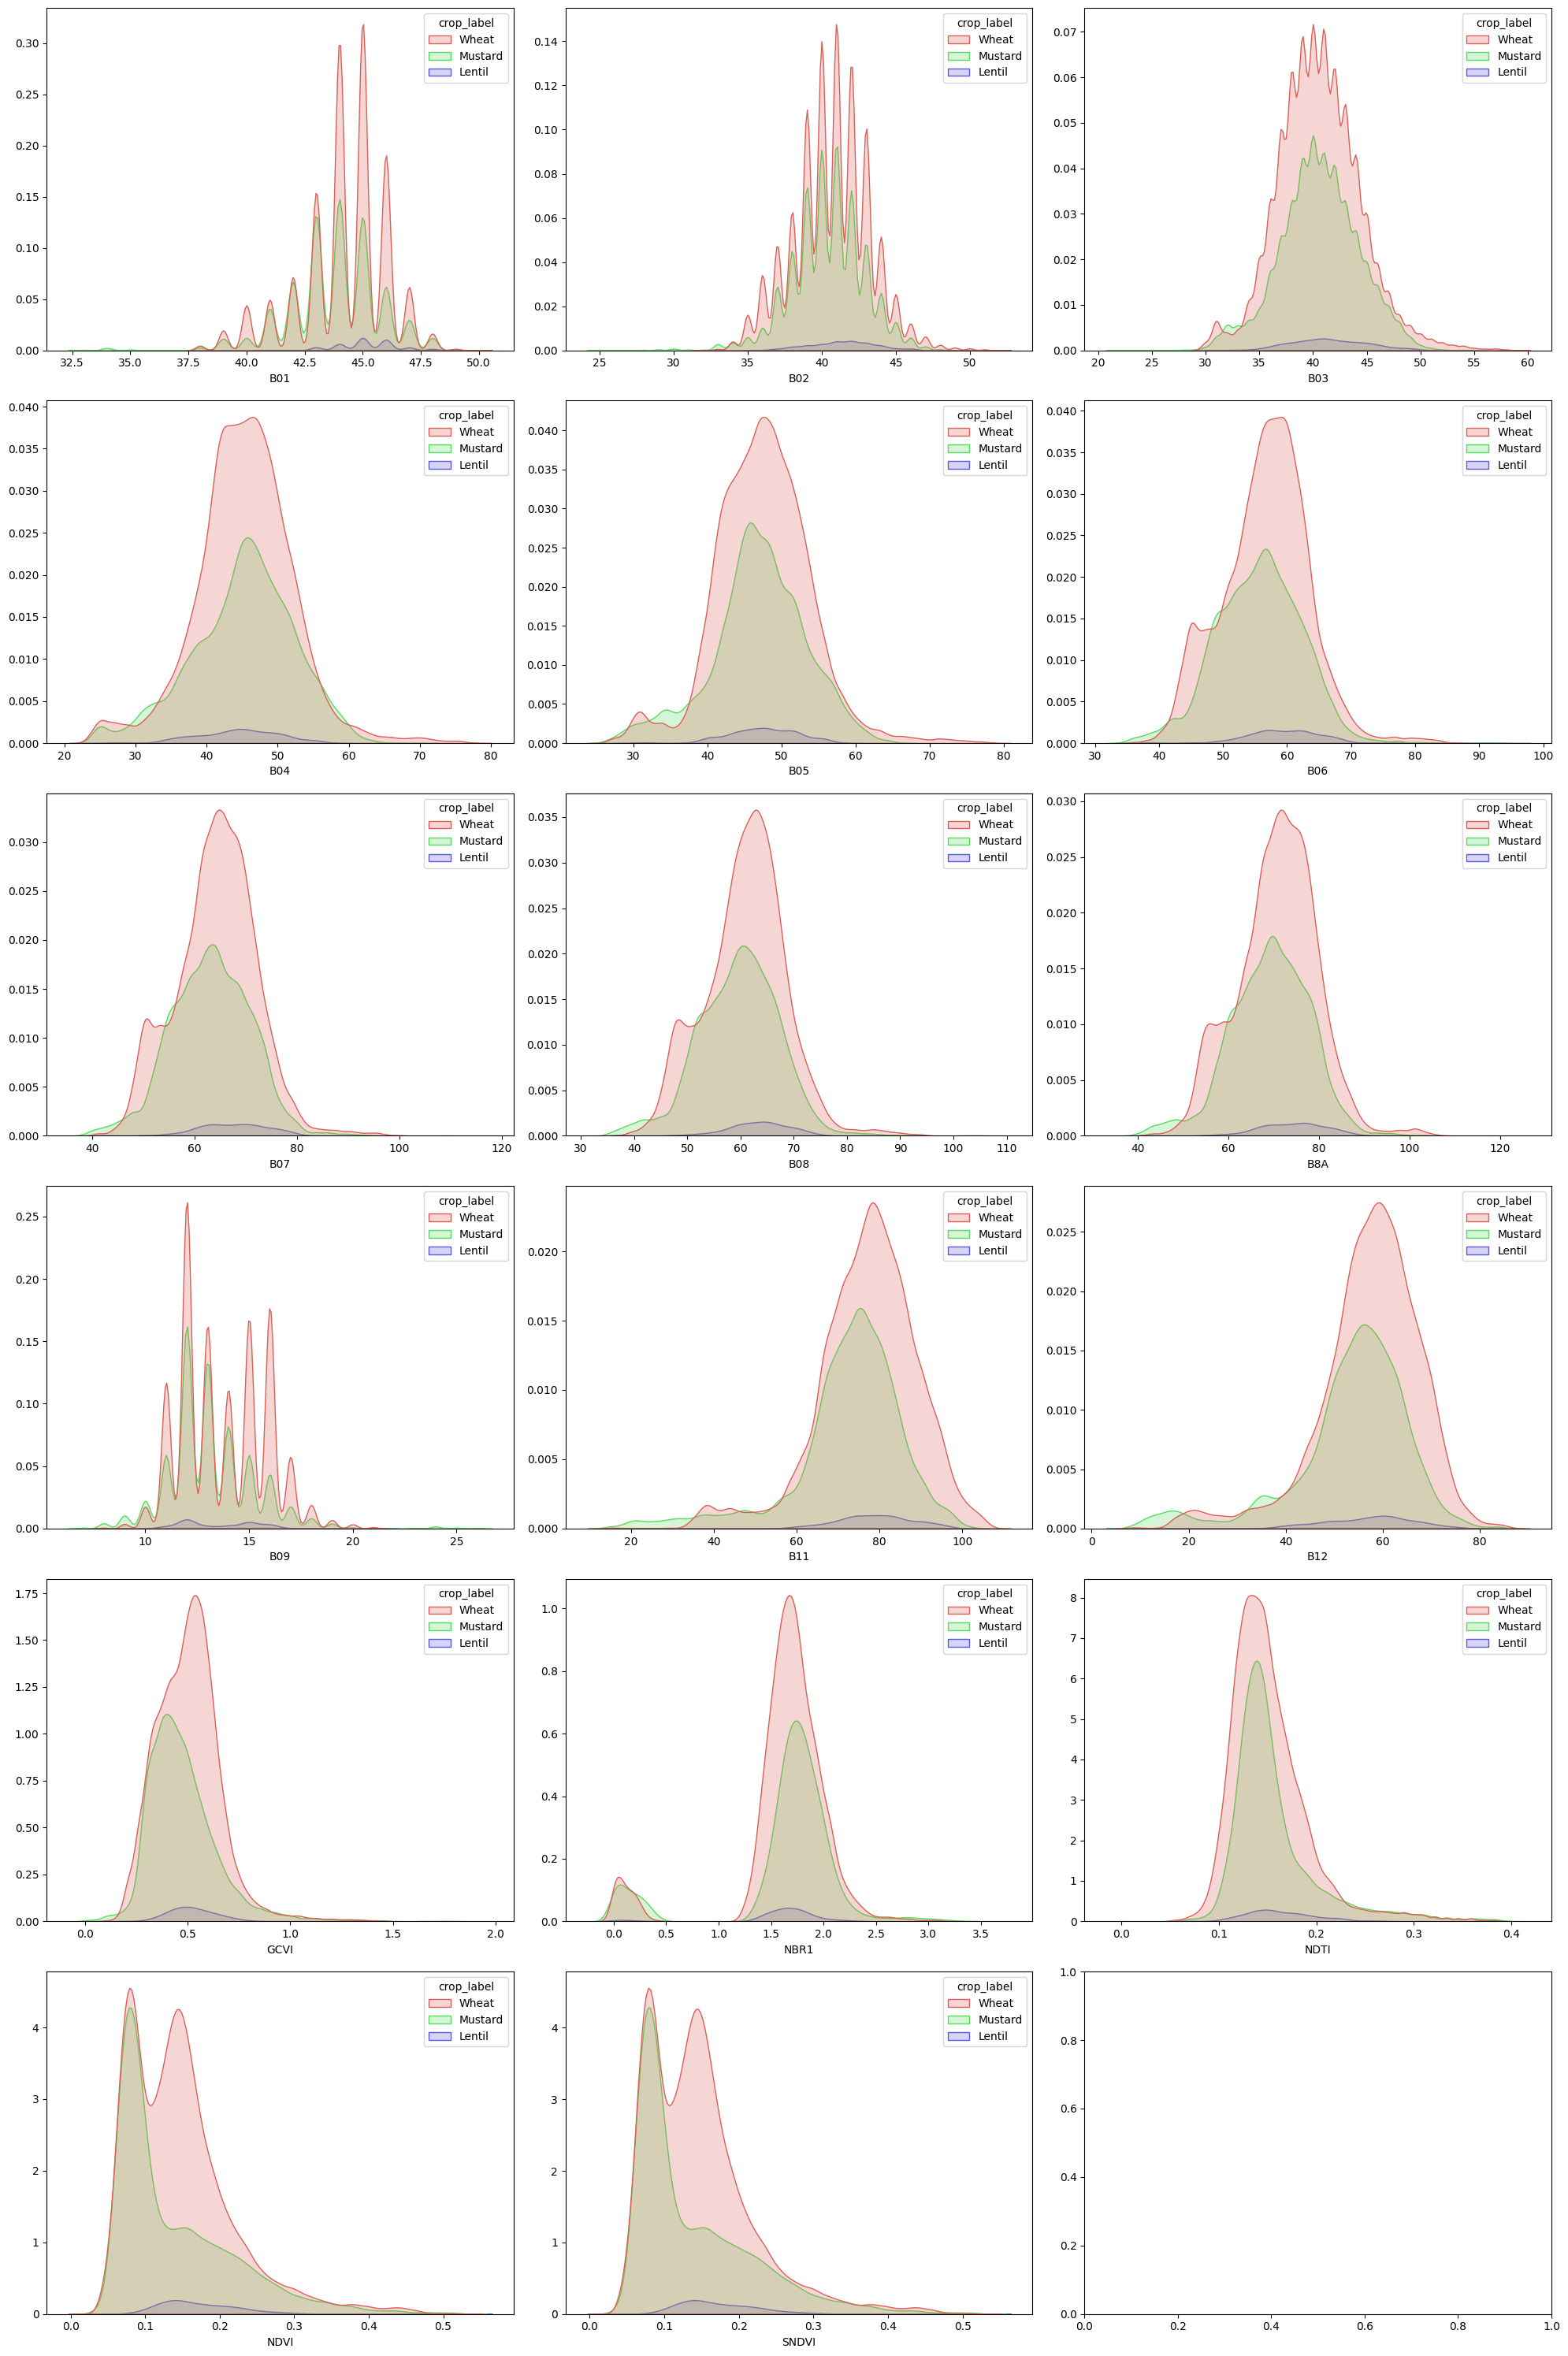

In [34]:
cur_df = df[df['crop_type'].isin([1, 2, 3])]
fig, axes = plt.subplots(6, 3, figsize = (20,30))
for ax, band in zip(axes.reshape(-1), BAND_NAMES + ADD_BANDS):
    sns.kdeplot(x = band, hue='crop_label', data = cur_df, 
                fill = True, ax = ax, 
                palette = sns.color_palette('hls', n_colors=3))
    ax.tick_params()
    ax.xaxis.get_label()
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

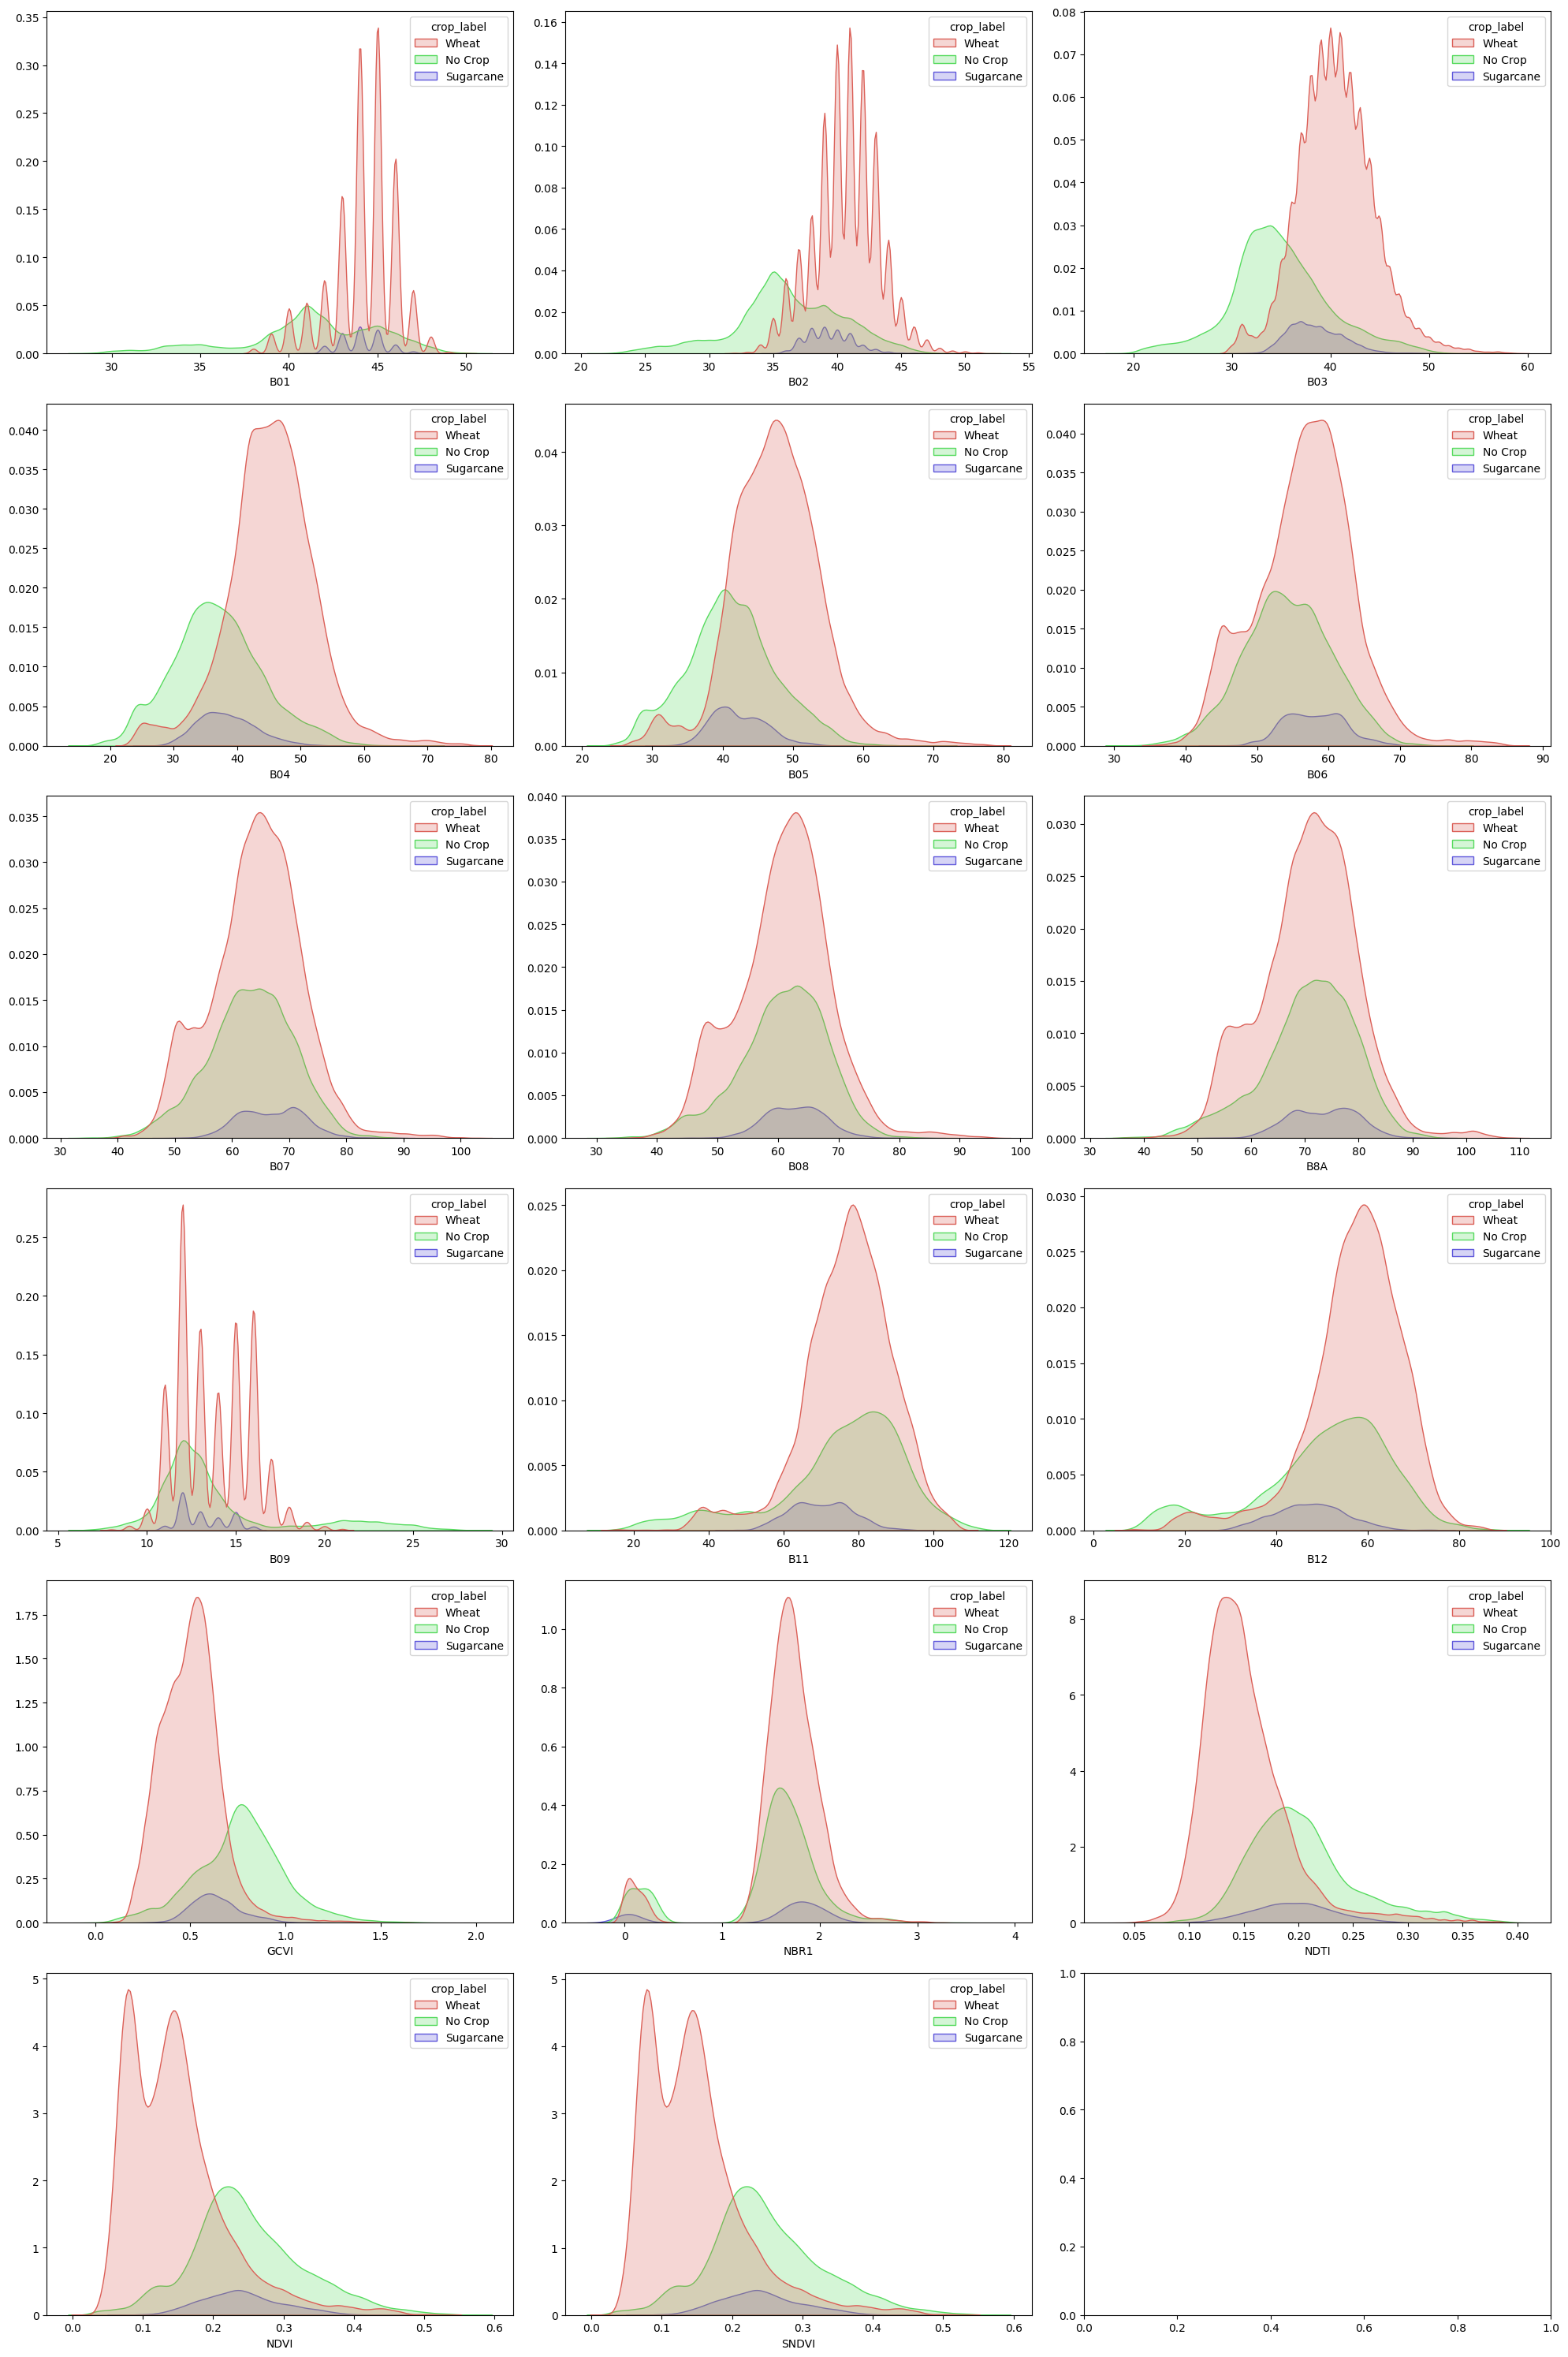

In [35]:
cur_df = df[df['crop_type'].isin([1, 4, 6])]
fig, axes = plt.subplots(6, 3, figsize = (20,30))
for ax, band in zip(axes.reshape(-1), BAND_NAMES + ADD_BANDS):
    sns.kdeplot(x = band, hue='crop_label', data = cur_df, 
                fill = True, ax = ax, 
                palette = sns.color_palette('hls', n_colors=3))
    ax.tick_params()
    ax.xaxis.get_label()
    ax.set_ylabel('')
plt.tight_layout()
plt.show()